# Data Cube of transmissions : Fit with Gaussian Processes



- Use GPy instead of scipy

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : January 7th 2027  
- update : January 11th 2021


- ** use kernel Python3_GPSS2021

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
import scipy
from scipy import interpolate

In [2]:
import os

In [3]:
print(sys.executable)
print(sys.version)
#print(sys.version_info)

/users/dagoret/anaconda3/envs/python_3_gpss2021/bin/python
3.7.11 (default, Jul 27 2021, 07:03:16) 
[Clang 10.0.0 ]


In [4]:
#from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.gaussian_process.kernels import RBF,WhiteKernel, ConstantKernel
import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy


In [5]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
#plt.rcParams['axes.formatter.useroffset']=  False

In [6]:
plt.rcParams.update({'figure.max_open_warning': 0})

In [7]:
!ls data

20200211-holo-4-003-uniformity-datacube.npy


# Configuration

In [8]:
WL=np.arange(350,1100,2)
NWL=len(WL)

In [9]:
XMIN = -4.5
XMAX = 4.5
YMIN = -4.5
YMAX = 4.5
NX=50
NY=50
xx=np.linspace(XMIN,XMAX,NX)
yy=np.linspace(YMIN,YMAX,NY)

In [10]:
grid_x, grid_y = np.mgrid[XMIN:XMAX:50j, YMIN:YMAX:50j]

In [11]:
cmap="jet"

# Utility Functions

In [12]:
def get_list_of_position(arr):
    """
    Return the list of positions
    """
    
    
    ListOfPositions = [] 
    arrsize=len(arr)
    Npos=0
    
    for idx in np.arange(arrsize):
    
        currentposition = (arr[idx][1], arr[idx][2] )
    
        if currentposition not in ListOfPositions:
            ListOfPositions.append(currentposition)
            Npos+=1
            
            
    return Npos, ListOfPositions
    

In [13]:
def get_list_of_transmissions(arr):
    """
    
    """
    
    Narr=len(arr)
    Npos,list_of_position = get_list_of_position(arr)
    
    collectedtransmissions = np.empty(Npos, dtype=np.object)
    
    for idx in np.arange(Narr):   
        currentposition = (arr[idx][1], arr[idx][2])
        currentvalues = (arr[idx][3],arr[idx][4], arr[idx][5] )
  
    
        idx2=-1
        for position in list_of_position:
            idx2+=1
            
            if position == currentposition:
            
                if collectedtransmissions[idx2] == None:
                    collectedtransmissions[idx2] = []
                    collectedtransmissions[idx2].append(currentvalues)
                else:
                    collectedtransmissions[idx2].append(currentvalues)
                       
    
    return collectedtransmissions    
       

In [14]:
def find_nearest_point(list_of_points,x0=0,y0=0):
    
    N=len(list_of_points)
    distances = []
    
    for pos in list_of_points:
        dx=pos[0]-x0
        dy=pos[1]-y0
        distances.append(np.sqrt(dx**2 + dy**2))
    
    distances = np.array(distances)
    
    idx0 = np.where(distances == distances.min())[0][0]
    
    return idx0,distances[idx0]
    

In [15]:
def get_transmission_center(arr,x0=0,y0=0):
    """
    return the transmission of existing position (x0,y0) 
    
    """
    
    wl0 = np.array([], dtype=np.float64)
    eff0 = np.array([], dtype=np.float64)
    eeff0 = np.array([], dtype=np.float64)
    
    Npos,list_of_position = get_list_of_position(arr)
    arr_ext = get_list_of_transmissions(arr)
    
    idx0,d0=find_nearest_point(list_of_position,x0=x0,y0=y0)
     
    
    # loop on different positions
    for idx in np.arange(Npos):    
        list_of_datapoints = arr_ext[idx]
        x,y = list_of_position[idx]
    
        if idx==idx0:
            wl,eff,eeff = zip(*list_of_datapoints)   
            wl0 = wl
            eff0 = eff
            eeff0 =eeff          
        
    return wl0,eff0,eeff0
       

# Read Input file

In [16]:
datadir="data"
files_list= os.listdir(datadir)
print(files_list)
filename=files_list[0]
fullfilename=os.path.join(datadir,filename)
print(fullfilename)

['20200211-holo-4-003-uniformity-datacube.npy']
data/20200211-holo-4-003-uniformity-datacube.npy


In [17]:
arr=np.load(fullfilename)

In [18]:
arr.shape

(3443,)

In [19]:
NARR=arr.shape[0]

In [20]:
arr

array([(0,  0.,  0., 400.014, 0.28404813, 7.02226350e-04),
       (0,  0.,  0., 419.989, 0.09057611, 2.22853061e-04),
       (0,  0.,  0., 440.023, 0.02899506, 5.77351450e-05), ...,
       (2, -4., -4., 519.984, 0.06957727, 9.21319092e-05),
       (2, -4., -4., 540.001, 0.05970568, 7.87463120e-05),
       (2, -4., -4., 559.997, 0.03172864, 4.54447038e-05)],
      dtype=[('order', '<i8'), ('dx', '<f8'), ('dy', '<f8'), ('wl', '<f8'), ('DE', '<f8'), ('DE_std', '<f8')])

In [21]:
order0 = arr["order"]== 0
order1 = arr["order"]== 1
order2 = arr["order"]== 2

In [22]:
arr_0 = arr[order0]
arr_1 = arr[order1]
arr_2 = arr[order2]

# Order 1

## List of positions

In [23]:
Npos1,list_of_position_1 = get_list_of_position(arr_1)

In [24]:
Npos1

48

In [25]:
print(list_of_position_1)

[(0.0, 0.0), (0.0, 1.0), (0.0, 2.0), (0.0, 4.0), (0.0, -1.0), (0.0, -2.0), (0.0, -4.0), (1.0, 0.0), (1.0, 1.0), (1.0, 2.0), (1.0, 4.0), (1.0, -1.0), (1.0, -2.0), (1.0, -4.0), (2.0, 0.0), (2.0, 1.0), (2.0, 2.0), (2.0, 4.0), (2.0, -1.0), (2.0, -2.0), (2.0, -4.0), (4.0, 0.0), (4.0, 1.0), (4.0, 2.0), (4.0, 4.0), (4.0, -1.0), (4.0, -2.0), (-1.0, 0.0), (-1.0, 1.0), (-1.0, 2.0), (-1.0, 4.0), (-1.0, -1.0), (-1.0, -2.0), (-1.0, -4.0), (-2.0, 0.0), (-2.0, 1.0), (-2.0, 2.0), (-2.0, 4.0), (-2.0, -1.0), (-2.0, -2.0), (-2.0, -4.0), (-4.0, 0.0), (-4.0, 1.0), (-4.0, 2.0), (-4.0, 4.0), (-4.0, -1.0), (-4.0, -2.0), (-4.0, -4.0)]


In [26]:
len(list_of_position_1)

48

## Find the list of different positions

In [27]:
arr_1_ext = get_list_of_transmissions(arr_1)

In [28]:
len(arr_1_ext)

48

## Plot transmissions

In [29]:
from matplotlib import cm, colors
values = np.linspace(-4.0, 4.0, 10)
norm = colors.Normalize(vmin=-4.0, vmax=4.0, clip=False)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
for value in values:
   print("%.2f" % value, "=",
      "red:%.2f" % mapper.to_rgba(value)[0],
      "green:%.2f" % mapper.to_rgba(value)[1],
      "blue:%.2f" % mapper.to_rgba(value)[2])

-4.00 = red:0.00 green:0.00 blue:1.00
-3.11 = red:0.22 green:0.22 blue:1.00
-2.22 = red:0.44 green:0.44 blue:1.00
-1.33 = red:0.67 green:0.67 blue:1.00
-0.44 = red:0.89 green:0.89 blue:1.00
0.44 = red:1.00 green:0.89 blue:0.89
1.33 = red:1.00 green:0.67 blue:0.67
2.22 = red:1.00 green:0.44 blue:0.44
3.11 = red:1.00 green:0.22 blue:0.22
4.00 = red:1.00 green:0.00 blue:0.00


Text(0.5, 0.98, 'Transmission for Order 1')

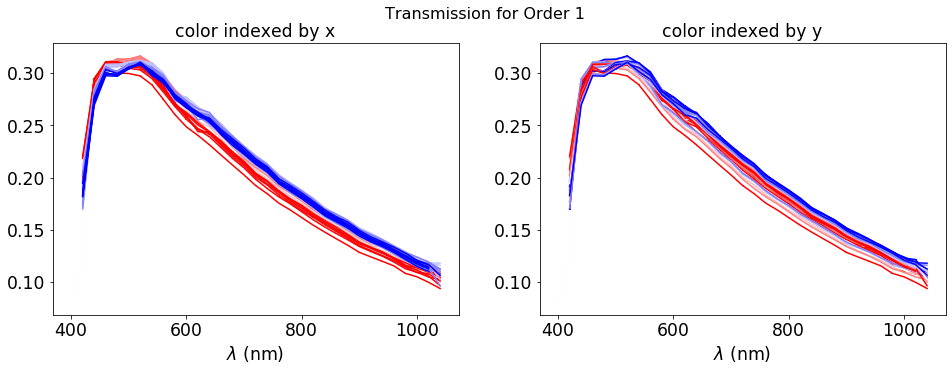

In [30]:
fig=plt.figure(figsize=(16,5))

fig.add_subplot(1,2,1)

for idx in np.arange(Npos1):    
    list_of_datapoints = arr_1_ext[idx]
    x,y = list_of_position_1[idx]
    c = mapper.to_rgba(x)
    wl,eff,eeff = zip(*list_of_datapoints)  
    
    if x==0 and y==0:
        wl0 = wl
        eff0 = eff
        f0 = interpolate.interp1d(wl0, eff0,kind='cubic')
    
    #plt.errorbar(wl,eff,yerr=eeff,color=c,uplims=True, lolims=True)
    plt.errorbar(wl,eff,yerr=eeff,color=c)  
    plt.title("color indexed by x")
    plt.xlabel("$\lambda$ (nm)")
 
fig.add_subplot(1,2,2)

for idx in np.arange(Npos1):    
    list_of_datapoints = arr_1_ext[idx]
    x,y = list_of_position_1[idx]
    c = mapper.to_rgba(y)
    wl,eff,eeff = zip(*list_of_datapoints)    
    #plt.errorbar(wl,eff,yerr=eeff,color=c,uplims=True, lolims=True)  
    plt.errorbar(wl,eff,yerr=eeff,color=c)  
    plt.title("color indexed by y")
    plt.xlabel("$\lambda$ (nm)")
    
plt.suptitle("Transmission for Order 1",fontsize=16)  

Text(0.5, 0.98, 'Transmission ratio for Order 1')

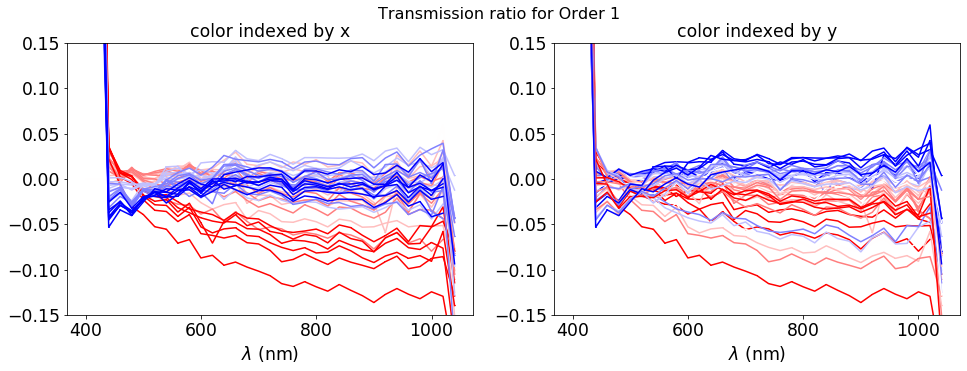

In [31]:
fig=plt.figure(figsize=(16,5))

fig.add_subplot(1,2,1)

for idx in np.arange(Npos1):    
    list_of_datapoints = arr_1_ext[idx]
    x,y = list_of_position_1[idx]
    
        
    c = mapper.to_rgba(x)
    wl,eff,eeff = zip(*list_of_datapoints) 
    
    f = interpolate.interp1d(wl, eff,kind='cubic')
    
    effr = f(wl)/f0(wl)-1 
    eeffr = eeff/f0(wl) 

    
    #plt.errorbar(wl,eff,yerr=eeff,color=c,uplims=True, lolims=True)
    plt.errorbar(wl,effr,yerr=eeff,color=c)  
    plt.title("color indexed by x")
    plt.xlabel("$\lambda$ (nm)")
    plt.ylim(-0.15,0.15)
 
fig.add_subplot(1,2,2)

for idx in np.arange(Npos1):    
    list_of_datapoints = arr_1_ext[idx]
    x,y = list_of_position_1[idx]
    c = mapper.to_rgba(y)
    wl,eff,eeff = zip(*list_of_datapoints)  
    
    f = interpolate.interp1d(wl, eff,kind='cubic')
    
    effr = f(wl)/f0(wl) -1
    eeffr = eeff/f0(wl) 

    
    #plt.errorbar(wl,eff,yerr=eeff,color=c,uplims=True, lolims=True)  
    plt.errorbar(wl,effr,yerr=eeff,color=c)  
    plt.title("color indexed by y")
    plt.xlabel("$\lambda$ (nm)")
    plt.ylim(-0.15,0.15)
    
plt.suptitle("Transmission ratio for Order 1",fontsize=16)  

# Fit with Gaussian Process

## Fit 1D Gaussian Process

In [32]:
idx_sel = 0

In [33]:
list_of_datapoints = arr_1_ext[idx_sel]
x,y = list_of_position_1[idx_sel]
wl,eff,eeff = zip(*list_of_datapoints)  

In [34]:
wl=np.array(wl)
eff=np.array(eff)
eeff=np.array(eeff)

In [35]:
N=len(wl)

In [36]:
ERRORFACTOR=1

(0.0, 0.35)

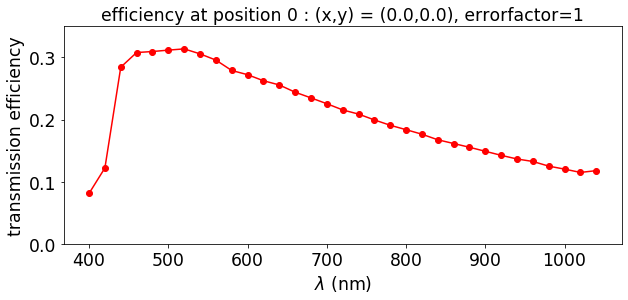

In [37]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax.errorbar(wl,eff,yerr=eeff*ERRORFACTOR,marker="o",ecolor="k",color="r")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission efficiency")
ax.set_title(f"efficiency at position {idx_sel} : (x,y) = ({x},{y}), errorfactor={ERRORFACTOR}")
ax.set_ylim(0.,0.35)

### utility functions

In [38]:
def fitGPyTransmission(wl,eff,efferr,errorfactor=1,flag_fixnoise=True):
    
    wl=np.array(wl)
    eff=np.array(eff)
    eeff=np.array(efferr)*errorfactor
    
    variance = np.mean(np.sum(eeff**2))
    
    N=len(wl)
    
    
    #kernel = 1 * RBF(length_scale=33.0, length_scale_bounds=(1e-1, 1e3))  
    #kernel = GPy.kern.RBF(1, variance=1., lengthscale=33.0, name="rbf") +  GPy.kern.White(1, variance=variance)
    kernel = GPy.kern.RBF(1, variance=1., lengthscale=33.0, name="rbf") 
    
    #gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=eeff ** 2, n_restarts_optimizer=0)
   
    
    X_train = wl[:, None]
    Y_train = eff[:, None] 
    EY_train = (eeff**2)[:,None]
    X = WL[:, None]
    
    
    #gaussian_process.fit(X_train, y_train)
    #m = GPy.models.GPRegression(X_train, Y_train, kernel,noise_var=EY_train)
    m = GPy.models.GPRegression(X_train, Y_train, kernel,noise_var=variance)
    
    # Constrain the regression parameters to be positive only
    m.constrain_positive()
    
    #specify noise on points
    #m.Gaussian_noise = variance  # put noise here
    if flag_fixnoise:
        m.Gaussian_noise.variance.fix() # does not optimize noise on points
    
    # optimize other parameters
    m.optimize()
  
    
    #print(gaussian_process.kernel_)
    
    #mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
    #mean_prediction, cov_prediction = m.predict(X, full_cov=True)
    # should call this :
    mean_prediction, cov_prediction = m.predict_noiseless(X, full_cov=True)
    
    return mean_prediction, cov_prediction, m

In [39]:
def plot_gpy(X, m, C, training_points=None,errorfactor=1,ax=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    
    
    if ax == None:
        fig = plt.figure(figsize=(10,4))
        ax = fig.add_subplot(1,1,1)
    
    # Plot 95% confidence interval 
    ax.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)),
                     m[:,0] + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.5,facecolor="cyan")
    # Plot GP mean and initial training points
    ax.plot(X, m, "r-")
    ax.legend(labels=["GP fit"])
    
    ax.set_xlabel("$\lambda$ (nm)") 
    ax.set_ylabel("transmission efficiency")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ , EY_ = training_points
        if EY_.all() == None :
            ax.plot(X_, Y_, "kx", mew=2)
        else:
            ax.errorbar(X_, Y_,yerr = EY_*errorfactor , marker="o",color="r",ecolor="k",lw=2)
            
        ax.legend(labels=["GP fit", "sample points"])
        
    ax.set_title(f"GP regression on efficiency at position {idx_sel} : (x,y) = ({x},{y}), errorfactor = {errorfactor}")

In [40]:
def plotfitGPTransmission(wl,eff,efferr,errorfactor=1,ax=None):
    
    mean_prediction, std_prediction, kparams  = fitGPTransmission(wl,eff,efferr,errorfactor=errorfactor)
    
    if ax == None:
        fig = plt.figure(figsize=(10,4))
        ax = fig.add_subplot(1,1,1)
        
    ax.errorbar(wl,eff,yerr=eeff,marker="o",ecolor="k",color="r",label="Observations")
    ax.plot(WL, mean_prediction, label="Mean prediction")
    ax.fill_between(
        WL,
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        alpha=0.5,
        label=r"95% confidence interval",color="cyan"
    )
    ax.legend()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("transmission efficiency")
    ax.set_title(f"GP regression on efficiency at position {idx_sel} : (x,y) = ({x},{y}), errorfactor={errorfactor}")
    ax.set_ylim(0.,0.5)
    
    

### 1D fit on the selected point

In [41]:
mean_prediction, cov_prediction , model = fitGPyTransmission(wl,eff,eeff,errorfactor=ERRORFACTOR)

reconstraining parameters GP_regression


In [42]:
display(model)

GP_regression.,value,constraints,priors
rbf.variance,0.02945671333735885,+ve,
rbf.lengthscale,31.37199802508295,+ve,
Gaussian_noise.variance,2.803563926405522e-06,fixed +ve,


In [43]:
X_train = wl[:,None]
Y_train = eff[:,None]
EY_train = eeff[:,None]
X = WL[:,None]

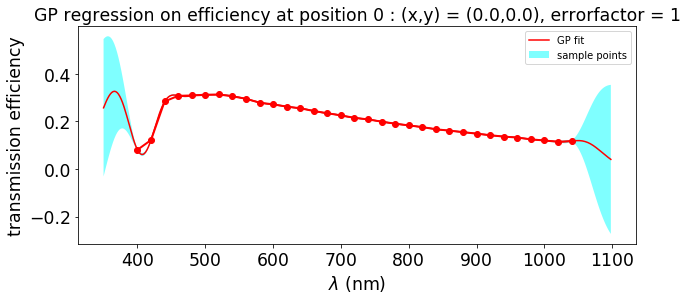

In [44]:
plot_gpy(X, mean_prediction, cov_prediction , training_points=(X_train,Y_train,EY_train),errorfactor=ERRORFACTOR)

### Loop on all points to fit a 1D gaussian process

reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.02945671333735885,+ve,
rbf.lengthscale,31.37199802508295,+ve,
Gaussian_noise.variance,2.803563926405522e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.04061846072460746,+ve,
rbf.lengthscale,66.30493250670881,+ve,
Gaussian_noise.variance,3.826610967144001e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.0630374153631374,+ve,
rbf.lengthscale,63.8298750294922,+ve,
Gaussian_noise.variance,3.7718191987581635e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.043071165612071215,+ve,
rbf.lengthscale,67.67598889709889,+ve,
Gaussian_noise.variance,3.69132519998642e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.04541904972727493,+ve,
rbf.lengthscale,67.10159723905927,+ve,
Gaussian_noise.variance,3.945221090234671e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.043714860942574145,+ve,
rbf.lengthscale,65.81243937372983,+ve,
Gaussian_noise.variance,3.952276696441824e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.04362195599465314,+ve,
rbf.lengthscale,68.26406775678676,+ve,
Gaussian_noise.variance,4.0563520814525205e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.06670363513194665,+ve,
rbf.lengthscale,67.73903676844238,+ve,
Gaussian_noise.variance,3.927939297845021e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.04915991485124634,+ve,
rbf.lengthscale,65.39044571208402,+ve,
Gaussian_noise.variance,3.869746907166493e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.04159268294936154,+ve,
rbf.lengthscale,68.95210247941705,+ve,
Gaussian_noise.variance,3.820836633320415e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.06345488499080389,+ve,
rbf.lengthscale,67.2663955559014,+ve,
Gaussian_noise.variance,3.679421976446267e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.07658728418254387,+ve,
rbf.lengthscale,68.09262296204513,+ve,
Gaussian_noise.variance,3.9728383104675e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.08553272767180578,+ve,
rbf.lengthscale,68.78406031666096,+ve,
Gaussian_noise.variance,4.001536759344144e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.05475287988896346,+ve,
rbf.lengthscale,68.11455420458915,+ve,
Gaussian_noise.variance,4.077580708723628e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.07634949400495267,+ve,
rbf.lengthscale,68.05139488327134,+ve,
Gaussian_noise.variance,3.913487887345922e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.059504404638965315,+ve,
rbf.lengthscale,69.59342253226313,+ve,
Gaussian_noise.variance,3.837462998182612e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.06808427981364569,+ve,
rbf.lengthscale,68.98482030329639,+ve,
Gaussian_noise.variance,3.7863596596441975e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.05675066098079815,+ve,
rbf.lengthscale,67.30549175729035,+ve,
Gaussian_noise.variance,3.6198073050911397e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.03105754749323388,+ve,
rbf.lengthscale,186.7449187839883,+ve,
Gaussian_noise.variance,3.845965315045376e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.08367564159382308,+ve,
rbf.lengthscale,65.45112834830071,+ve,
Gaussian_noise.variance,4.010341131731506e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.05168566723651815,+ve,
rbf.lengthscale,68.86566867049945,+ve,
Gaussian_noise.variance,4.082284927523883e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.08552985498750551,+ve,
rbf.lengthscale,70.40709854669255,+ve,
Gaussian_noise.variance,3.744448729610169e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.06140726423255334,+ve,
rbf.lengthscale,68.25007631123825,+ve,
Gaussian_noise.variance,3.680162667797214e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.04469343716484743,+ve,
rbf.lengthscale,69.9511358916183,+ve,
Gaussian_noise.variance,3.621557567543985e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.033409670019240334,+ve,
rbf.lengthscale,66.48914467038149,+ve,
Gaussian_noise.variance,3.423569397147053e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.05975560506767002,+ve,
rbf.lengthscale,65.80250275952058,+ve,
Gaussian_noise.variance,3.792466427094104e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.06070320478323166,+ve,
rbf.lengthscale,65.41978957371097,+ve,
Gaussian_noise.variance,3.843897711691206e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.048525447740478546,+ve,
rbf.lengthscale,67.99142114883186,+ve,
Gaussian_noise.variance,3.868712345315639e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.07103350255642113,+ve,
rbf.lengthscale,66.48393500967343,+ve,
Gaussian_noise.variance,3.80941019611018e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.10770497336906068,+ve,
rbf.lengthscale,68.93592890388038,+ve,
Gaussian_noise.variance,3.7437438683467623e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.038265481559805185,+ve,
rbf.lengthscale,69.30819847148555,+ve,
Gaussian_noise.variance,3.703790749183469e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.05256883704377624,+ve,
rbf.lengthscale,67.63926772658583,+ve,
Gaussian_noise.variance,3.869737479660027e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.05165641648136602,+ve,
rbf.lengthscale,67.83994891150677,+ve,
Gaussian_noise.variance,3.934681124255952e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.06538685895374576,+ve,
rbf.lengthscale,65.07492629450918,+ve,
Gaussian_noise.variance,3.9790876504746066e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.051677600547212155,+ve,
rbf.lengthscale,65.86801902121096,+ve,
Gaussian_noise.variance,3.7967805345901017e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.03924995333849945,+ve,
rbf.lengthscale,57.761796496692966,+ve,
Gaussian_noise.variance,3.7510348835314647e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.03975630893288676,+ve,
rbf.lengthscale,67.89996428743869,+ve,
Gaussian_noise.variance,3.730131383666949e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.04813162277994624,+ve,
rbf.lengthscale,63.02562378304309,+ve,
Gaussian_noise.variance,3.6833430520596026e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.045957315460595526,+ve,
rbf.lengthscale,68.96549474126984,+ve,
Gaussian_noise.variance,3.837252068132644e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.06785326548883545,+ve,
rbf.lengthscale,65.16283766849266,+ve,
Gaussian_noise.variance,3.853341104281064e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.042754364341544296,+ve,
rbf.lengthscale,68.71162139143249,+ve,
Gaussian_noise.variance,3.927150113042524e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.03510471471415187,+ve,
rbf.lengthscale,65.65070071015752,+ve,
Gaussian_noise.variance,3.68680741426631e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.027260766665292913,+ve,
rbf.lengthscale,159.33608357708582,+ve,
Gaussian_noise.variance,3.524112305390022e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.047806421938632326,+ve,
rbf.lengthscale,65.13047667688745,+ve,
Gaussian_noise.variance,3.6382886774539655e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.05010415056171242,+ve,
rbf.lengthscale,65.5466457313096,+ve,
Gaussian_noise.variance,3.6069803030010962e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.044470859878227874,+ve,
rbf.lengthscale,64.33934374569604,+ve,
Gaussian_noise.variance,3.6832345532834393e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.04107961391345933,+ve,
rbf.lengthscale,65.3026830154295,+ve,
Gaussian_noise.variance,3.7203055241603335e-06,fixed +ve,


reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.041282728806605114,+ve,
rbf.lengthscale,65.96108723073999,+ve,
Gaussian_noise.variance,3.7890448405090495e-06,fixed +ve,


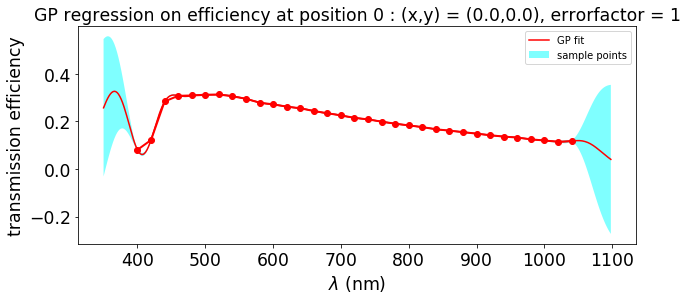

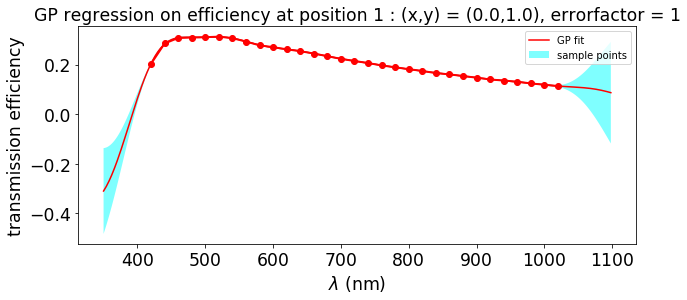

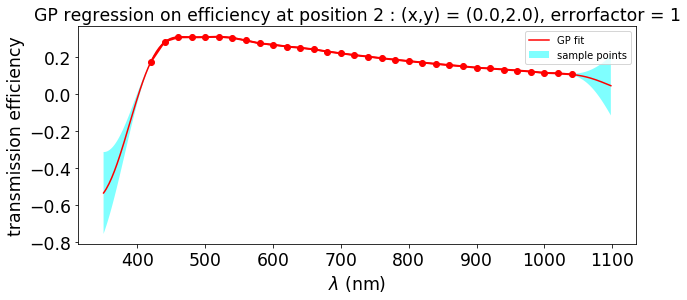

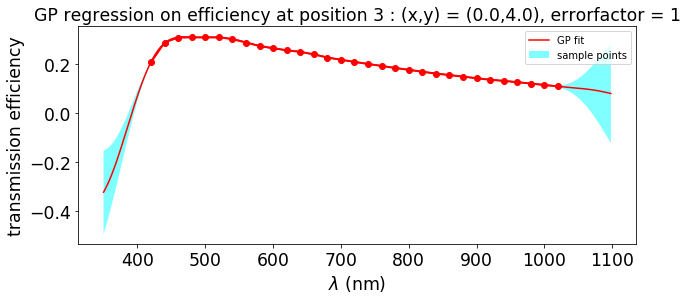

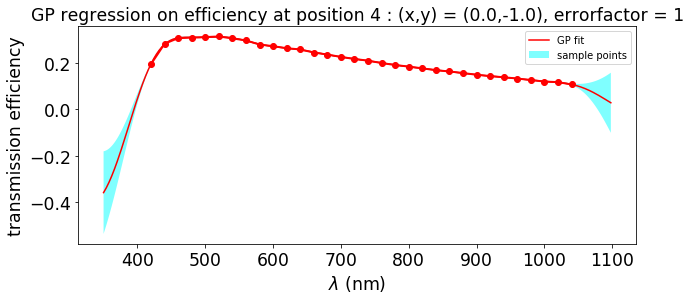

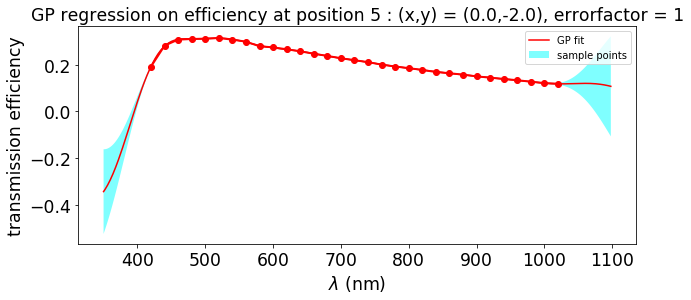

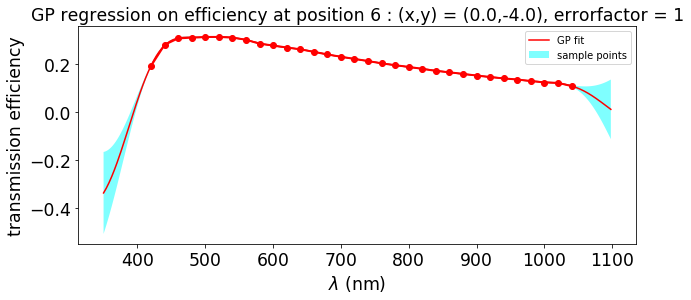

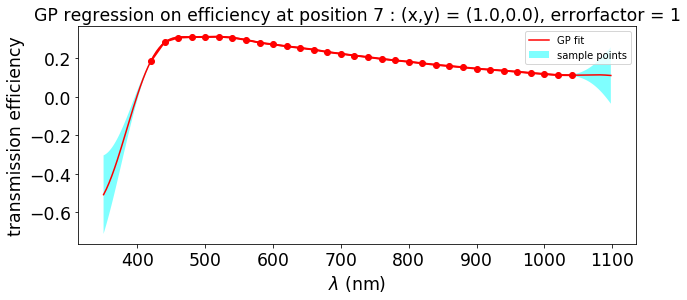

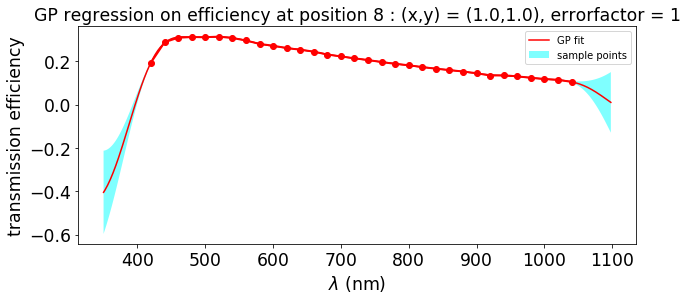

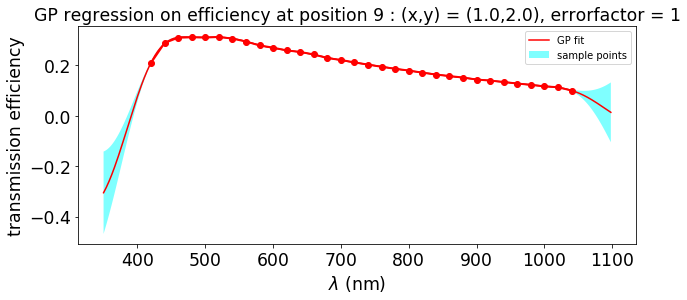

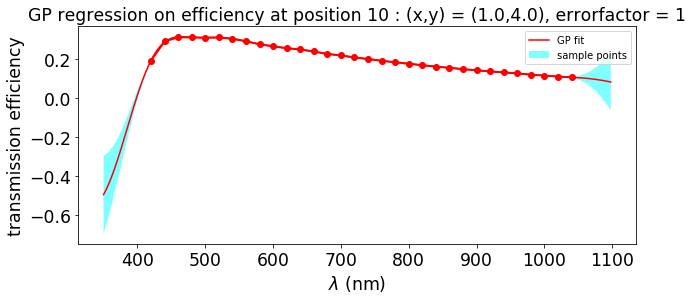

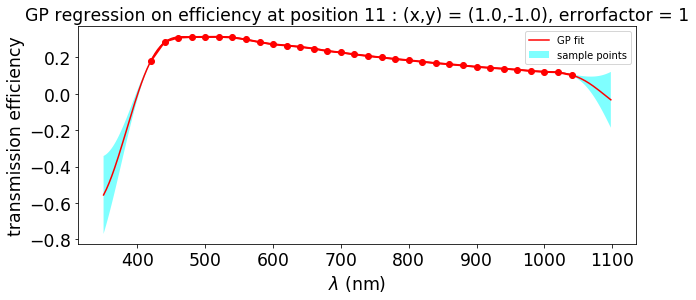

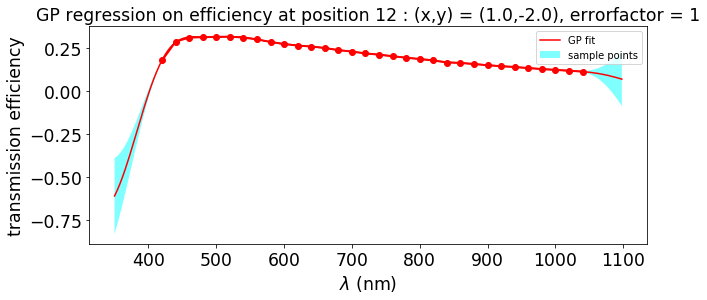

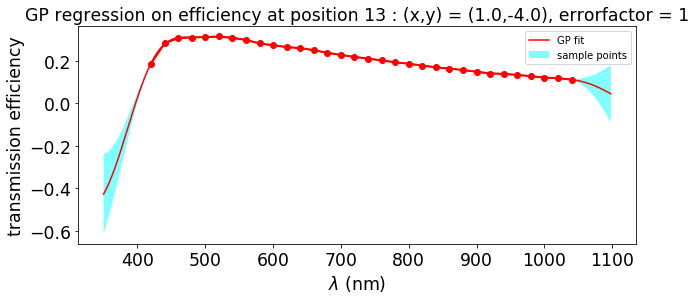

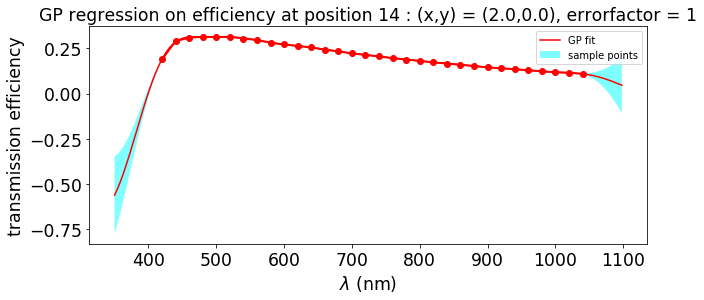

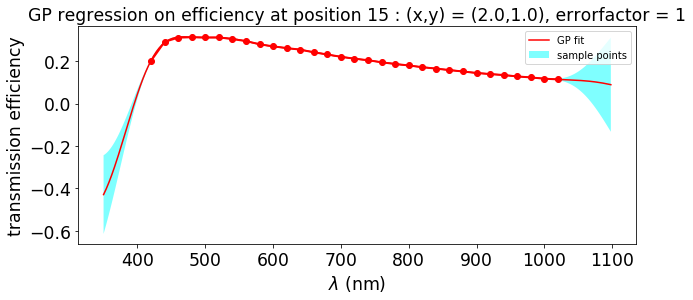

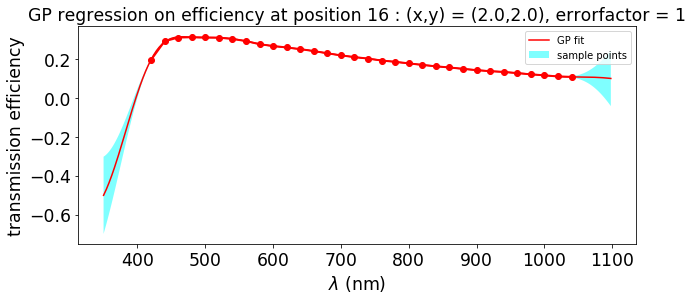

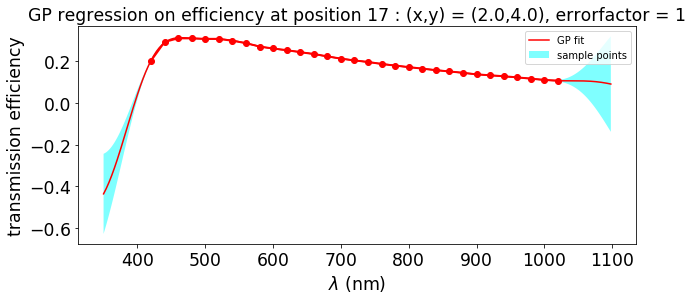

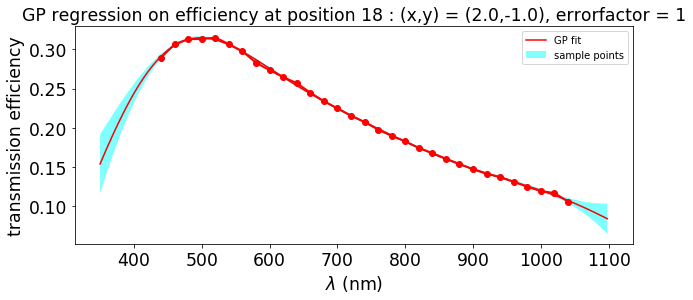

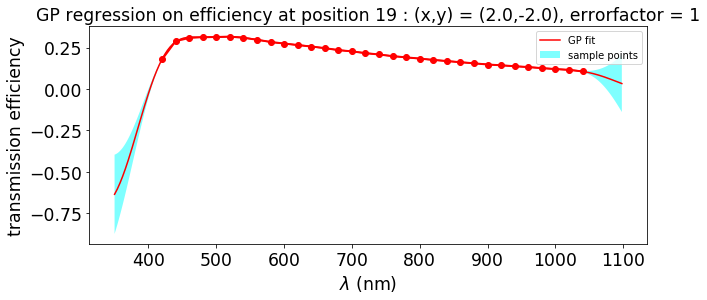

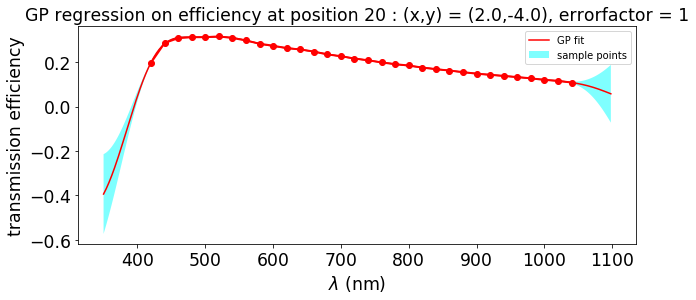

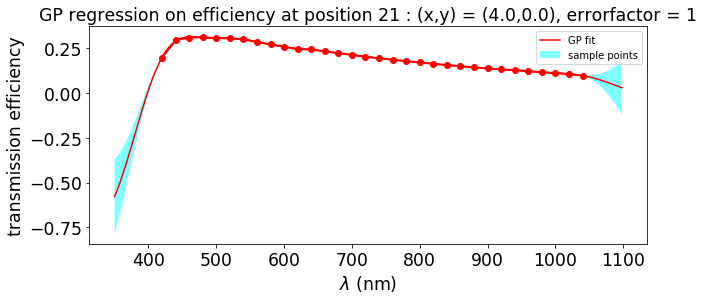

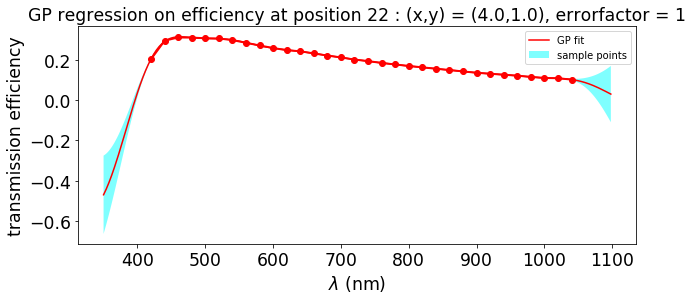

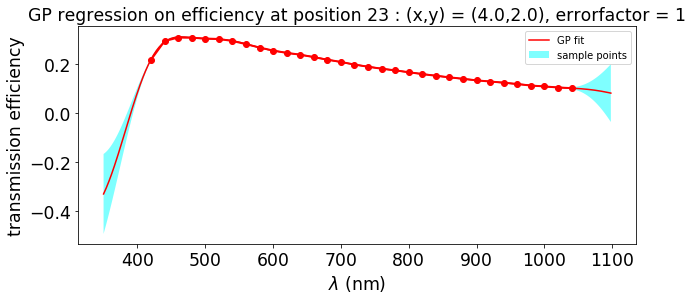

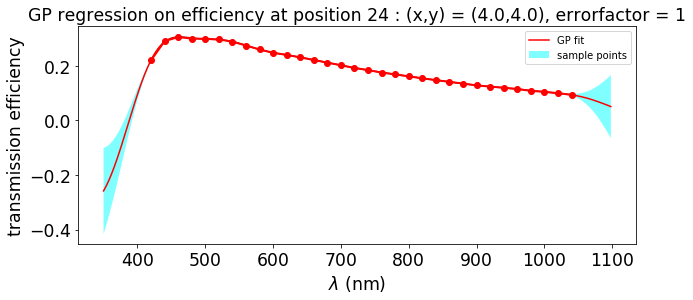

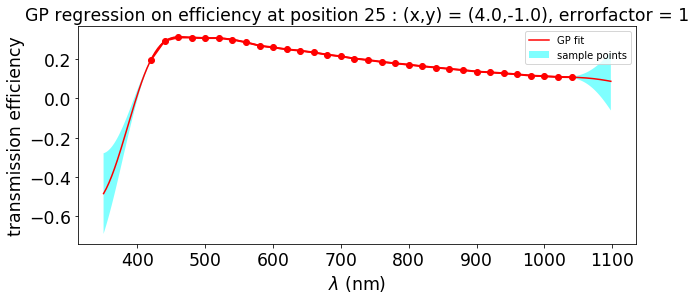

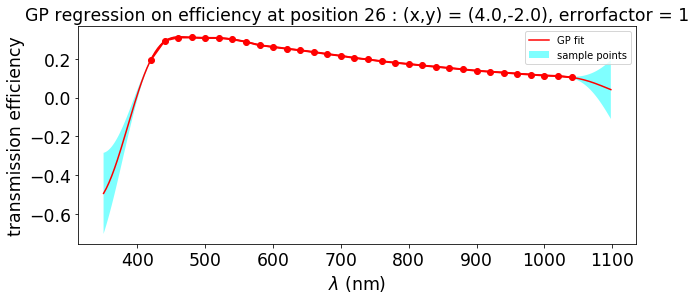

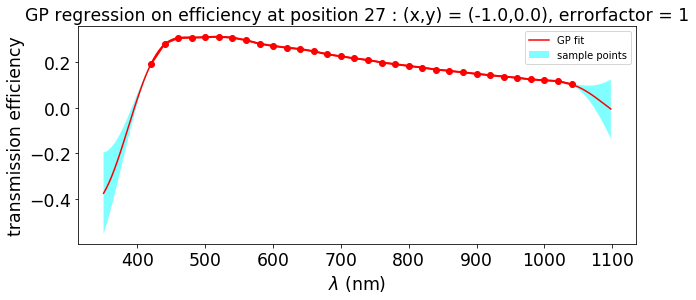

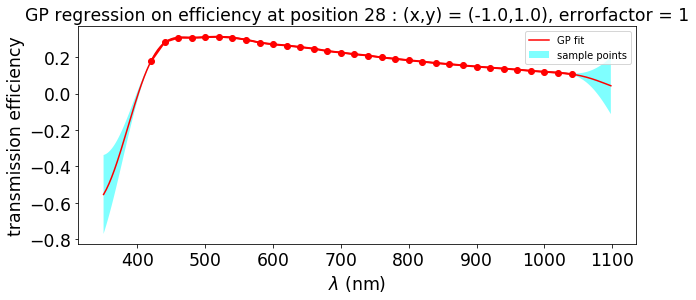

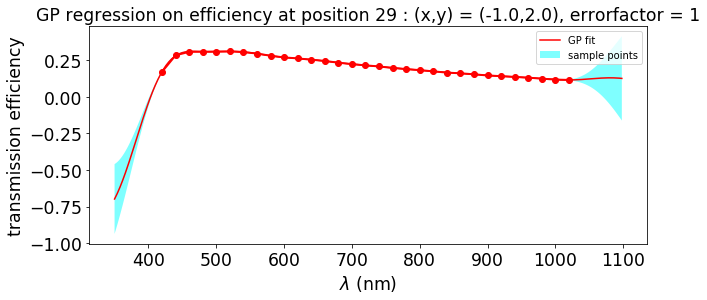

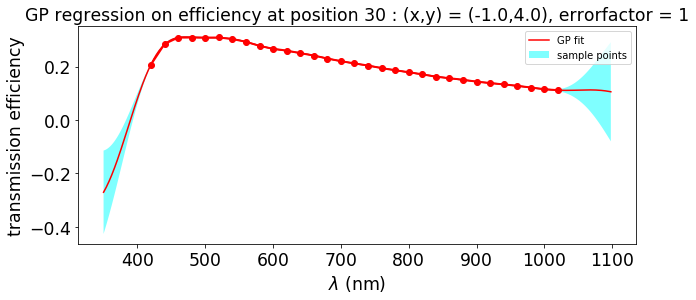

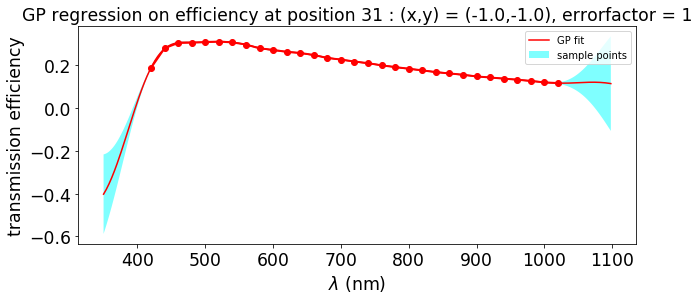

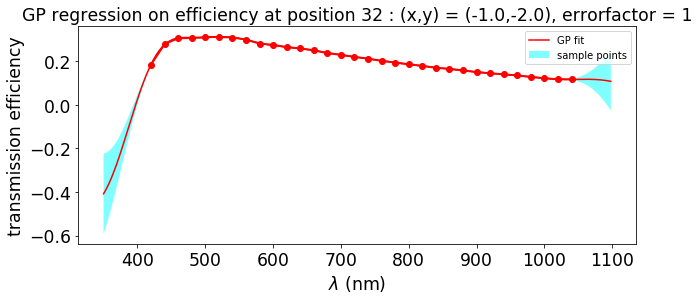

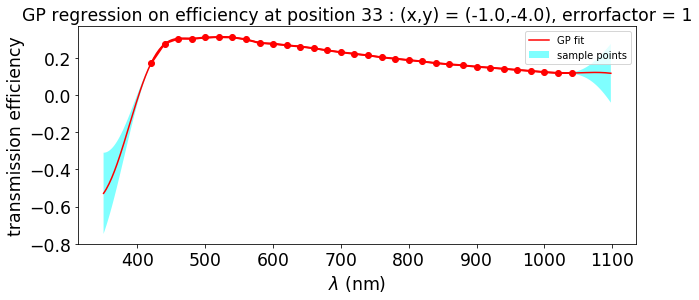

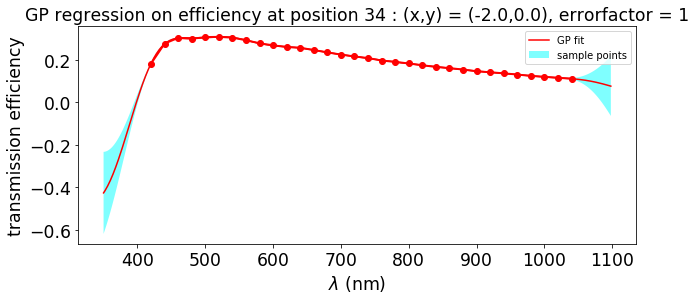

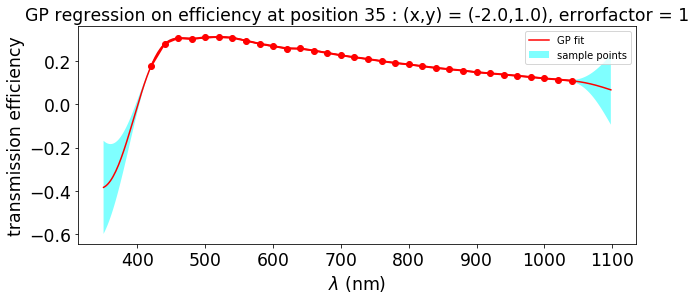

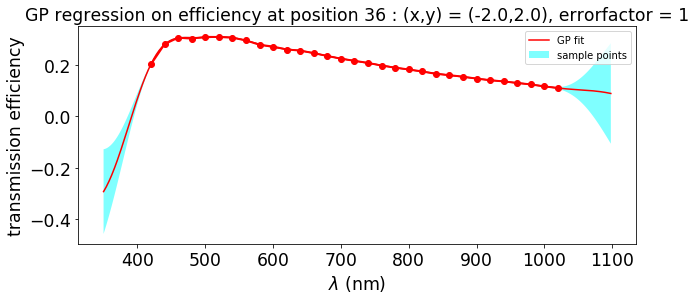

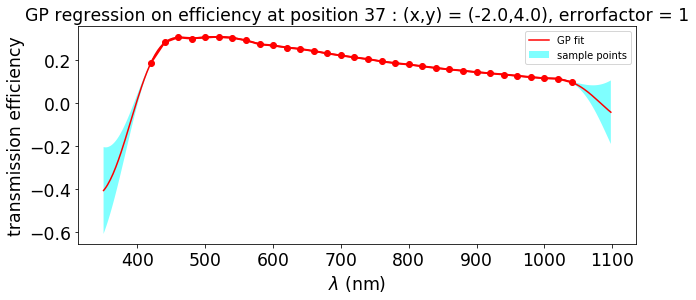

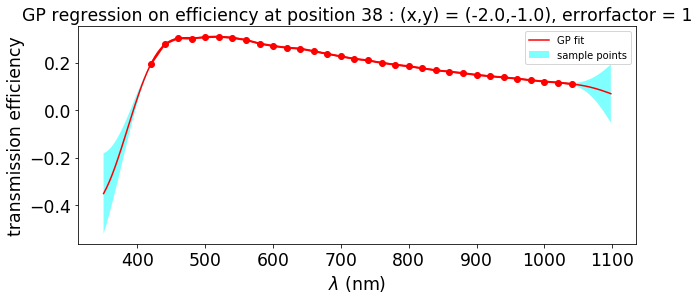

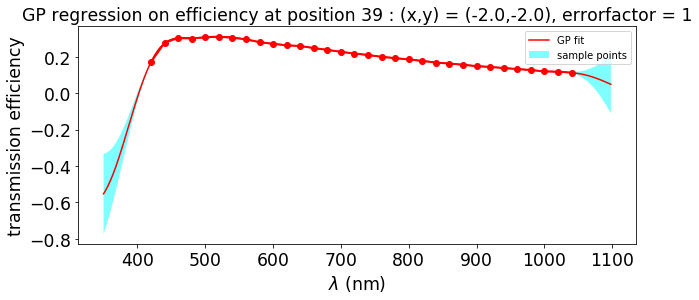

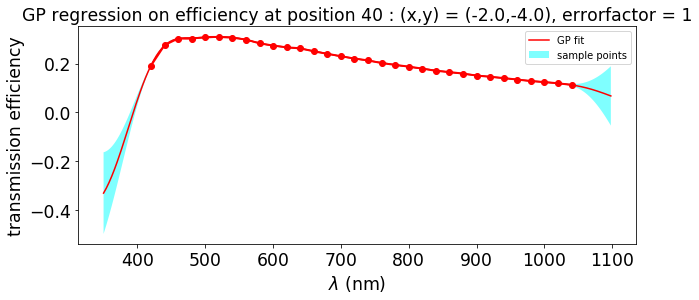

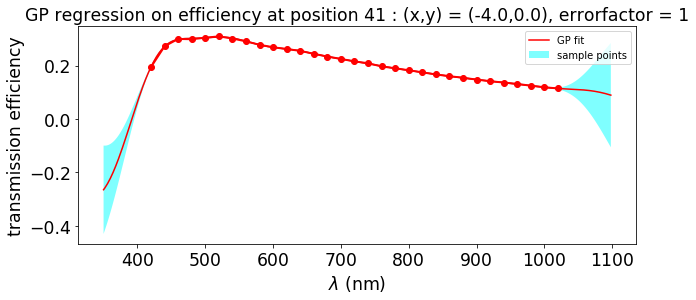

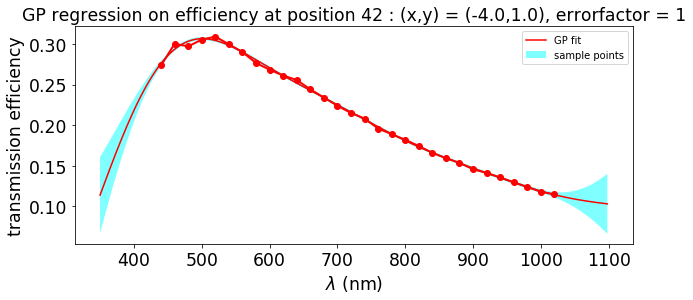

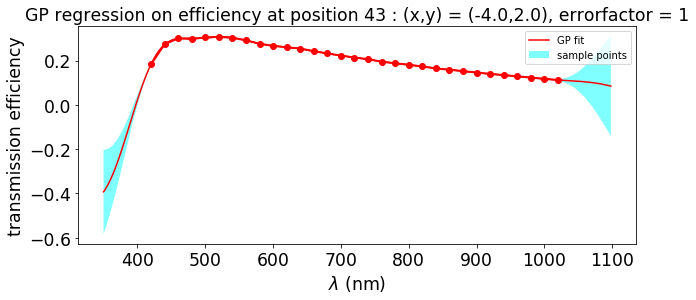

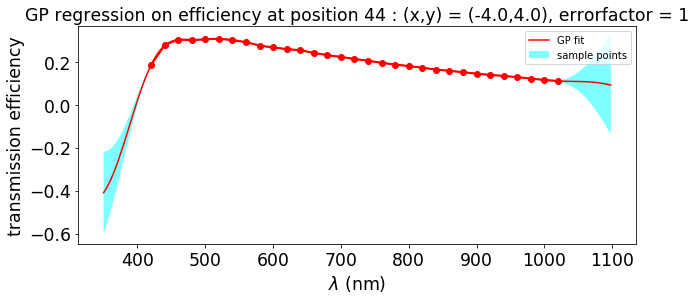

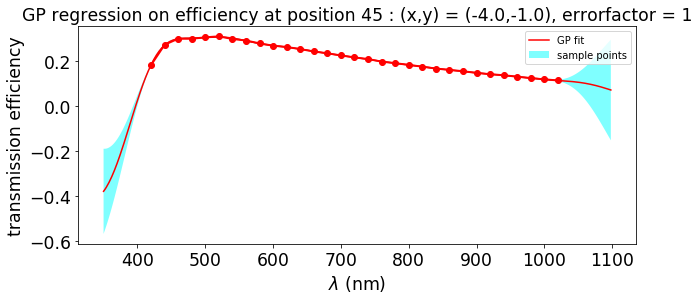

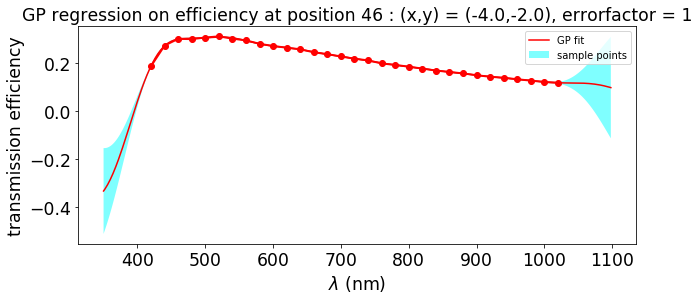

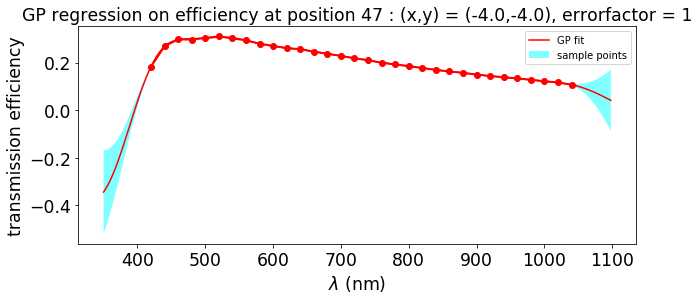

In [45]:
for idx_sel in np.arange(Npos1):    
    list_of_datapoints = arr_1_ext[idx_sel]
    x,y = list_of_position_1[idx_sel]
    wl,eff,eeff = zip(*list_of_datapoints)  
    
    mean_prediction, cov_prediction , model = fitGPyTransmission(wl,eff,eeff,errorfactor=ERRORFACTOR)
    
    display(model)
    
    
    X_train = np.array(wl)[:,None]
    Y_train = np.array(eff)[:,None]
    EY_train = np.array(eeff)[:,None]
    X = WL[:,None]
    
    plot_gpy(X, mean_prediction, cov_prediction , training_points=(X_train,Y_train,EY_train),errorfactor=ERRORFACTOR)
    
  

### Loop on all examples to find the hyper - parameters of the kernel

In [46]:
all_k1 = np.zeros(Npos1)
all_k2 = np.zeros(Npos1)
for idx_sel in np.arange(Npos1):    
    list_of_datapoints = arr_1_ext[idx_sel]
    x,y = list_of_position_1[idx_sel]
    wl,eff,eeff = zip(*list_of_datapoints)  
    
    
    mean_prediction, cov_prediction , model = fitGPyTransmission(wl,eff,eeff,errorfactor=ERRORFACTOR)
    
    k1 = model.rbf.variance[0]
    k2 = model.rbf.lengthscale[0]
    all_k1[idx_sel] = k1
    all_k2[idx_sel] = k2

reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression
reconstraining parameters GP_regression


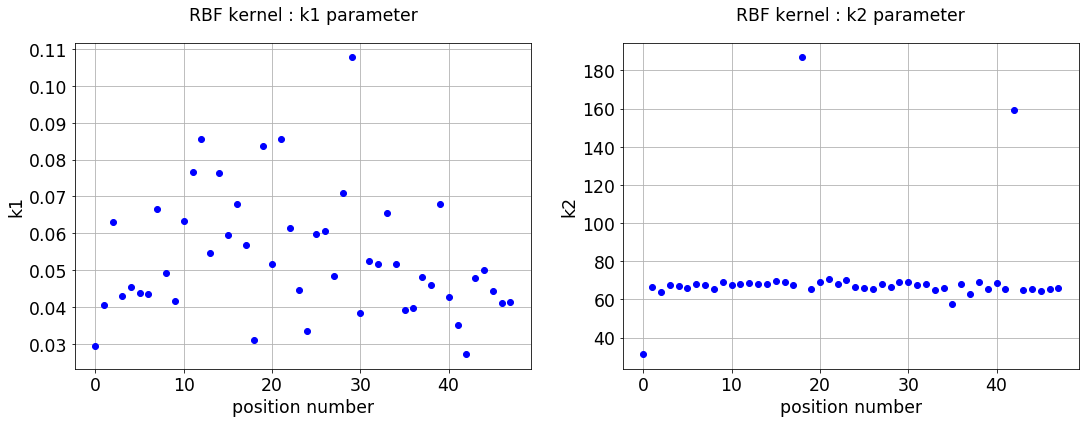

In [47]:
fig = plt.figure(figsize=(18,6))
ax=fig.add_subplot(1,2,1)
ax.plot(all_k1,'bo')
#plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
ax.set_xlabel("position number")
ax.set_ylabel("k1")
ax.set_title("RBF kernel : k1 parameter",y=1.05)
ax.grid()
ax=fig.add_subplot(1,2,2)
ax.plot(all_k2,'bo')
#plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
ax.set_xlabel("position number")
ax.set_ylabel("k2")
ax.set_title("RBF kernel : k2 parameter",y=1.05)
ax.grid()

## Fit 3D Gaussian Process

### create data arrays

In [48]:
arr_1

array([(1,  0.,  0.,  400.014, 0.08113432, 0.00042531),
       (1,  0.,  0.,  419.989, 0.12204722, 0.00055285),
       (1,  0.,  0.,  440.023, 0.28427847, 0.0003543 ), ...,
       (1, -4., -4.,  999.966, 0.12115345, 0.00016043),
       (1, -4., -4., 1019.98 , 0.11694063, 0.00014926),
       (1, -4., -4., 1040.023, 0.10674954, 0.00015927)],
      dtype=[('order', '<i8'), ('dx', '<f8'), ('dy', '<f8'), ('wl', '<f8'), ('DE', '<f8'), ('DE_std', '<f8')])

In [49]:
arr=arr_1
Narr = len(arr)
X_train = np.zeros((Narr,3))
Y_train = np.zeros((Narr,1))
EY_train = np.zeros((Narr,1))
              
for idx in np.arange(Narr):    

    X_train[idx,0]=arr[idx][1]
    X_train[idx,1]=arr[idx][2]
    X_train[idx,2]=arr[idx][3]
    
    Y_train[idx,0]=arr[idx][4]
    EY_train[idx,0] = arr[idx][5]*ERRORFACTOR

In [50]:
X_train

array([[   0.   ,    0.   ,  400.014],
       [   0.   ,    0.   ,  419.989],
       [   0.   ,    0.   ,  440.023],
       ...,
       [  -4.   ,   -4.   ,  999.966],
       [  -4.   ,   -4.   , 1019.98 ],
       [  -4.   ,   -4.   , 1040.023]])

In [51]:
Y_train

array([[0.08113432],
       [0.12204722],
       [0.28427847],
       ...,
       [0.12115345],
       [0.11694063],
       [0.10674954]])

In [52]:
EY_train

array([[0.00042531],
       [0.00055285],
       [0.0003543 ],
       ...,
       [0.00016043],
       [0.00014926],
       [0.00015927]])

### kernel

In [53]:
variance = np.mean(np.sum(EY_train**2,axis=0))

In [54]:
variance

0.00018173585164990016

In [55]:
kernel = GPy.kern.RBF(3, ARD=True, name="rbf3d") 

### Regression

In [56]:
model = GPy.models.GPRegression(X_train, Y_train, kernel,noise_var=variance)

In [57]:
# Constrain the regression parameters to be positive only
model.constrain_positive()

reconstraining parameters GP_regression


In [58]:
model.Gaussian_noise.variance.fix() # does not optimize noise on points

array([0])

In [59]:
model.optimize()

In [60]:
model

GP_regression.,value,constraints,priors
rbf3d.variance,0.04618665018388595,+ve,
rbf3d.lengthscale,"(3,)",+ve,
Gaussian_noise.variance,0.00018173585164990016,fixed +ve,


In [61]:
model.rbf3d.lengthscale

index,GP_regression.rbf3d.lengthscale,constraints,priors
[0],211.08223927,+ve,
[1],243.76430838,+ve,
[2],1.00000000,+ve,


In [62]:
model.rbf3d.lengthscale = [1,1,60]
model.rbf3d.lengthscale.fix()

array([0, 1, 2])

In [63]:
model.rbf3d.lengthscale

index,GP_regression.rbf3d.lengthscale,constraints,priors
[0],1.00000000,fixed +ve,
[1],1.00000000,fixed +ve,
[2],60.00000000,fixed +ve,


In [64]:
model.Gaussian_noise.variance.fix() # does not optimize noise on points

array([0])

In [65]:
model.Gaussian_noise.variance[0]

0.00018173585164990016

In [66]:
#mean_prediction, cov_prediction = m.predict_noiseless(X, full_cov=True)

### Plot WL vs X

In [67]:
newx,newy = np.meshgrid(xx,WL)

In [68]:
newy

array([[ 350,  350,  350, ...,  350,  350,  350],
       [ 352,  352,  352, ...,  352,  352,  352],
       [ 354,  354,  354, ...,  354,  354,  354],
       ...,
       [1094, 1094, 1094, ..., 1094, 1094, 1094],
       [1096, 1096, 1096, ..., 1096, 1096, 1096],
       [1098, 1098, 1098, ..., 1098, 1098, 1098]])

In [69]:
N=np.ravel(newx).shape[0]
N

18750

In [70]:
N=np.ravel(newy).shape[0]
N

18750

In [71]:
y_position_value=0.0
y_fixed = np.full((N, ), y_position_value)

In [72]:
Xpred = np.stack([np.ravel(newx), y_fixed, np.ravel(newy)], axis=1)

In [73]:
Xpred

array([[  -4.5       ,    0.        ,  350.        ],
       [  -4.31632653,    0.        ,  350.        ],
       [  -4.13265306,    0.        ,  350.        ],
       ...,
       [   4.13265306,    0.        , 1098.        ],
       [   4.31632653,    0.        , 1098.        ],
       [   4.5       ,    0.        , 1098.        ]])

In [74]:
mean_prediction , _ = model.predict_noiseless(Xpred, full_cov=True)

In [75]:
eff_gp3d_prediction = mean_prediction

In [76]:
eff_gp3d_prediction

array([[-0.08045638],
       [-0.08977893],
       [-0.09818233],
       ...,
       [ 0.04886546],
       [ 0.04539094],
       [ 0.04114512]])

In [77]:
eff_gp3d_prediction [np.where(eff_gp3d_prediction<0)[0]] = 0
eff_gp3d_prediction [np.where(eff_gp3d_prediction>0.4)[0]] = 0

In [78]:
Z = eff_gp3d_prediction.reshape(newx.shape)

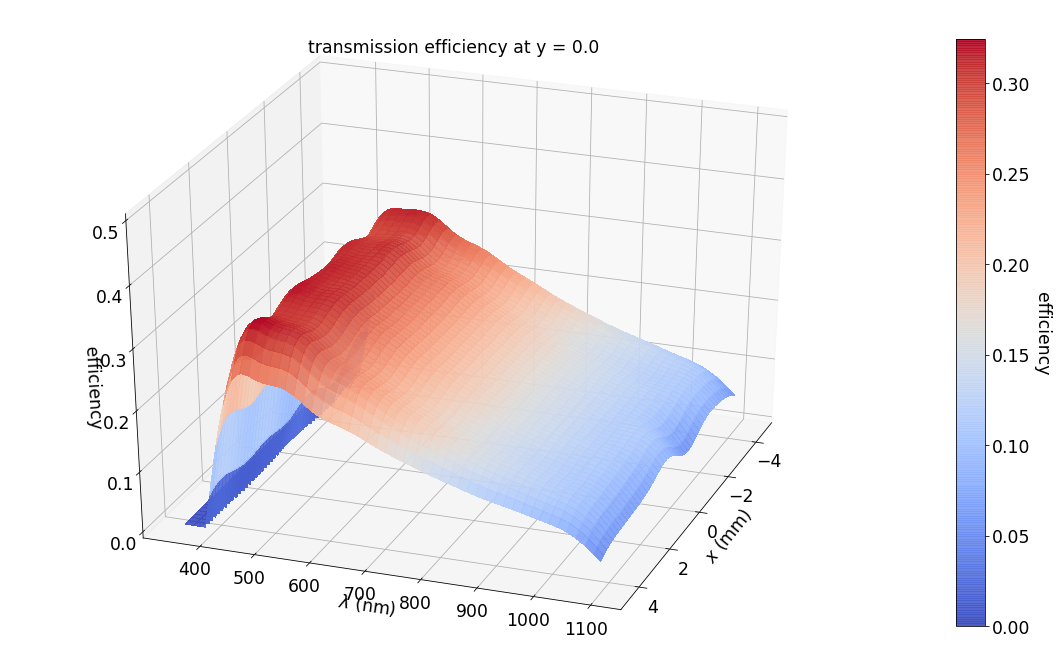

In [79]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(30, 20)
surf = ax.plot_surface(newx, newy, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False, shade = True, alpha = 0.9)
#ax.clabel(cset, fontsize=9, inline=1)
ax.set_zlim(0,0.5)
ax.set_ylabel("$\lambda$ (nm)")
ax.set_xlabel("$x$ (mm)")
ax.invert_xaxis()
ax.set_zlabel("efficiency")
ax.set_title(f"transmission efficiency at y = {y_position_value}")
cbar=fig.colorbar(surf, shrink=0.9)
cbar.set_label('efficiency', rotation=270)
cbar.ax.get_yaxis().labelpad = 20
#fig.colorbar(surf)
plt.show()

### Plot WL vs y

In [80]:
newx,newy = np.meshgrid(yy,WL)

In [81]:
N=np.ravel(newx).shape[0]
N

18750

In [82]:
N=np.ravel(newy).shape[0]
N

18750

In [83]:
x_position_value=0
x_fixed = np.full((N, ), x_position_value)

In [84]:
Xpred = np.stack([x_fixed, np.ravel(newx) ,np.ravel(newy)], axis=1)

In [85]:
Xpred

array([[   0.        ,   -4.5       ,  350.        ],
       [   0.        ,   -4.31632653,  350.        ],
       [   0.        ,   -4.13265306,  350.        ],
       ...,
       [   0.        ,    4.13265306, 1098.        ],
       [   0.        ,    4.31632653, 1098.        ],
       [   0.        ,    4.5       , 1098.        ]])

In [86]:
eff_gp3d_prediction , _ =  model.predict_noiseless(Xpred, full_cov=True)

In [87]:
eff_gp3d_prediction [np.where(eff_gp3d_prediction<0)[0]] = 0
eff_gp3d_prediction [np.where(eff_gp3d_prediction>0.4)[0]] = 0

In [88]:
Z = eff_gp3d_prediction.reshape(newx.shape)

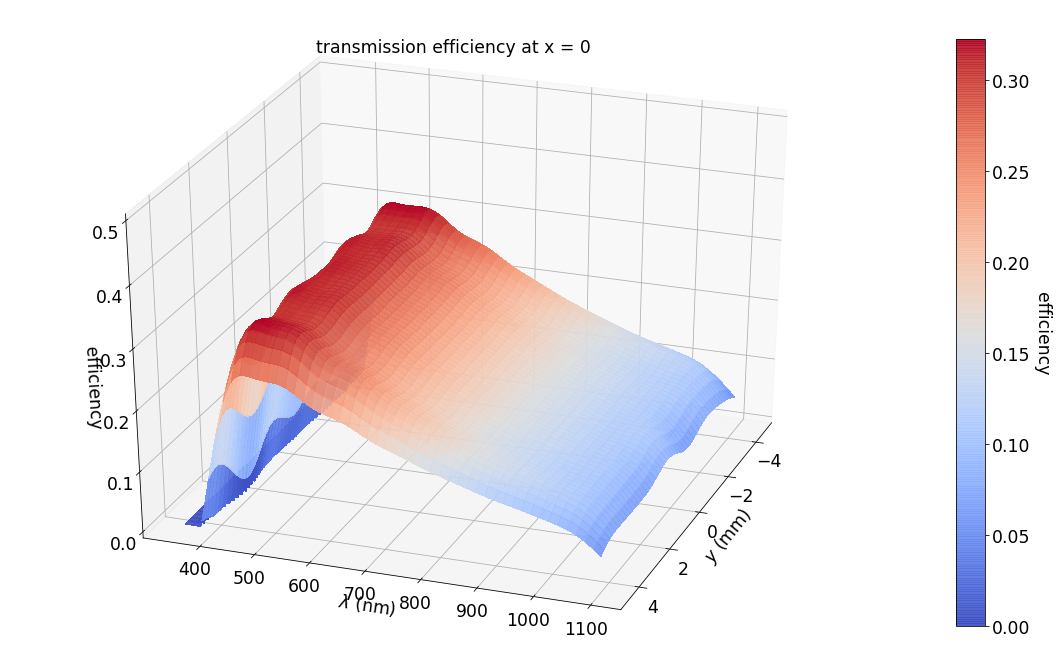

In [89]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(30, 20)
surf = ax.plot_surface(newx, newy, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False, shade = True, alpha = 0.9)
#ax.clabel(cset, fontsize=9, inline=1)
ax.set_zlim(0,0.5)
ax.set_ylabel("$\lambda$ (nm)")
ax.set_xlabel("$y$ (mm)")
ax.invert_xaxis()
ax.set_zlabel("efficiency")
ax.set_title(f"transmission efficiency at x = {x_position_value}")
#fig.colorbar(surf, shrink=0.5, aspect=5)
cbar = fig.colorbar(surf, shrink=0.9)
cbar.set_label('efficiency', rotation=270)
cbar.ax.get_yaxis().labelpad = 20
plt.show()